# Event Centering 2021-04-14

Goal of this notebook is to test out functions for event centering on 1 day, 1 neuron. And then, 1 day, all neurons. And then all days all neurons. Plan is to save out as dicts (nested) to used for later analysis specific to delay period analysis.

### Libs & Utils

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
from tqdm import tqdm
from scipy import stats
from scipy.ndimage import gaussian_filter1d
# stored one repo up in my fork of Spykes
# from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

### Load session

Here, I'm loading in one session (08-06-2019) that has 4 cells 

In [2]:
sess_name = 'W122_08_06_2019_1_fromSD'

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'

# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
# fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# alginment info (hard coded here & in fx)
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 
         'delay2s', 'trial2s', 'delay4s', 'trial4s']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000],
           [-150, 2150],[-200, 2400], [-150, 4150], [-200, 4400]]

align_windows = dict(zip(names,windows))


# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)
delay_analysis_df = beh_df[(beh_df['delay'] != 6) & (beh_df['first_sound'] != 'psycho') &
                                     (beh_df['hit_hist'] != 'viol')]

sess_aligned = event_align_session(spks_dict, delay_analysis_df, sess_path, overwrite=False, 
                                   file_name='delay_analysis_aligned_spks.pkl')

loading from file...


### PSTHs

Stopped here--- TODO:
* update psth_gaussain to only take sigma
* fix legend
* make a fx to wrap around for saving?
* make 2s and 4s delay plots for all neurons in session
    * remove psycho from event_centering
* expand to multiple neurons
* expand to multiple sessions

### make into fx

Note: for delay plots, will want to save the mean firing rate as well to make another mean. So maybe so something like spykes where raster saves out and plot option can be toggled

In [3]:
del_2_df = delay_analysis_df[(delay_analysis_df['delay'] == 2)] # & (beh_df['first_sound'] != 'psycho')]
del_4_df =delay_analysis_df[(delay_analysis_df['delay'] == 4)]

I'm not sure which kernal is better. I like the ease of the scipy stats kernal and how it truncates at 4 sd, but I worry that the area will not be equal to 1 and this is supressing the firing rate artificially. Update: in comparison with my homemade kernal given similar params and mode='constant', the firing rate between the two convolutions is similarly supressed. Overall, it seems like the 'wrap' mode best replicates the boxcar

In [4]:
fig_save_path = os.path.join(os.getcwd(), 'figures', 'test')

In [12]:
summary_loudness = []
summary_stats = []
for n in range(len(sess_aligned)):
    
    neuron_id = sess_name + '_N' + str(n)
    
    psth_g = PSTH_gaussain(sess_aligned[n], align_windows, 'delay2s', del_2_df, conditions='first_sound', sigma=150)
    psth_b = PSTH_boxcar(sess_aligned[n], align_windows, 'delay2s', del_2_df, conditions='first_sound', bin_size=0.150)
    
    # initialize psth plot
    fig, ax = plt.subplots(2,1, figsize = (15,12))
    
    # calculate psth via gaussian and boxcar
    plot_psth(psth_g, ax[0], legend=True, title=neuron_id)
    plot_psth(psth_b, ax[1])
    
    # save out
    fig_name = f"{neuron_id}_delay2s_psth"
    plt.tight_layout()
    plt.savefig(os.path.join(fig_save_path, fig_name))
    plt.close("all") 
    
    # initialize loundess regression
    fig2,ax2 = plt.subplots(1,1, figsize=(8,5))
    
    # extract data
    df = fr_by_loudness_df(psth_g, neuron_id)
    summary_loudness.append(df)
    
    # plot & regress
    regression_stats = regress_loudness_and_plot(df, ax=ax2)
    summary_stats.append(regression_stats)
    
    # save out
    fig_name = f"{neuron_id}_delay2s_loudness"
    plt.tight_layout()
    plt.savefig(os.path.join(fig_save_path, fig_name))
    plt.close("all") 

# concat & save out data frames used for regression
stats_df = pd.concat(summary_stats)
stats_df.reset_index().to_csv(os.path.join(base_path, sess_name, 'fr_by_loduness.csv'))

loudness_df = pd.concat(summary_loudness)
loudness_df.reset_index().to_csv(os.path.join(base_path, sess_name, 'fr_by_loudness_regression.csv'))

C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:396: RuntimeWarning: Mean of empty slice
  mean_fr_by_cond.append(np.nanmean(trial_psth[150:-150]))
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:396: RuntimeWarning: Mean of empty slice
  mean_fr_by_cond.append(np.nanmean(trial_psth[150:-150]))
C:\Users\JB\github\jbreda_PWM_ephys_analysis\plotting_utils.py:396: RuntimeWarning: Mean of empty slice
  mean_fr_by_cond.append(np.nanmean(trial_psth[150:-150]))


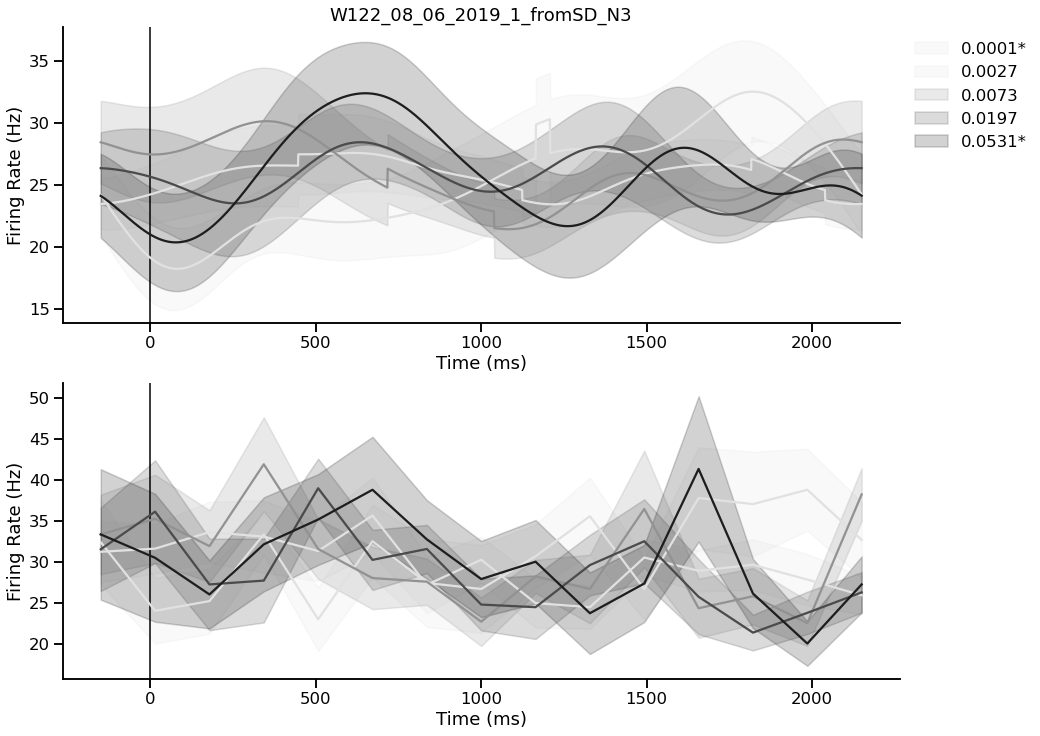

In [13]:
neuron = 0

g = PSTH_gaussain(sess_aligned[neuron], align_windows, 'delay2s', del_2_df, conditions='first_sound', sigma=150)
b = PSTH_boxcar(sess_aligned[neuron], align_windows, 'delay2s', del_2_df, conditions='first_sound', bin_size=0.150)
fig, ax = plt.subplots(2, 1, figsize = (15, 12))

plot_psth(g,axis=ax[0], legend=True, title=neuron_id)
plot_psth(b,axis=ax[1])

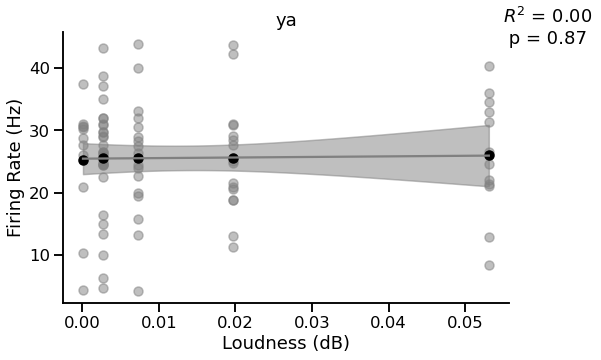

In [10]:
fig, ax = plt.subplots(1,1, figsize=(8,5))
df = fr_by_loudness_df(g,'ya')
reg = loudness_regression(df,ax=ax)

### Rasters

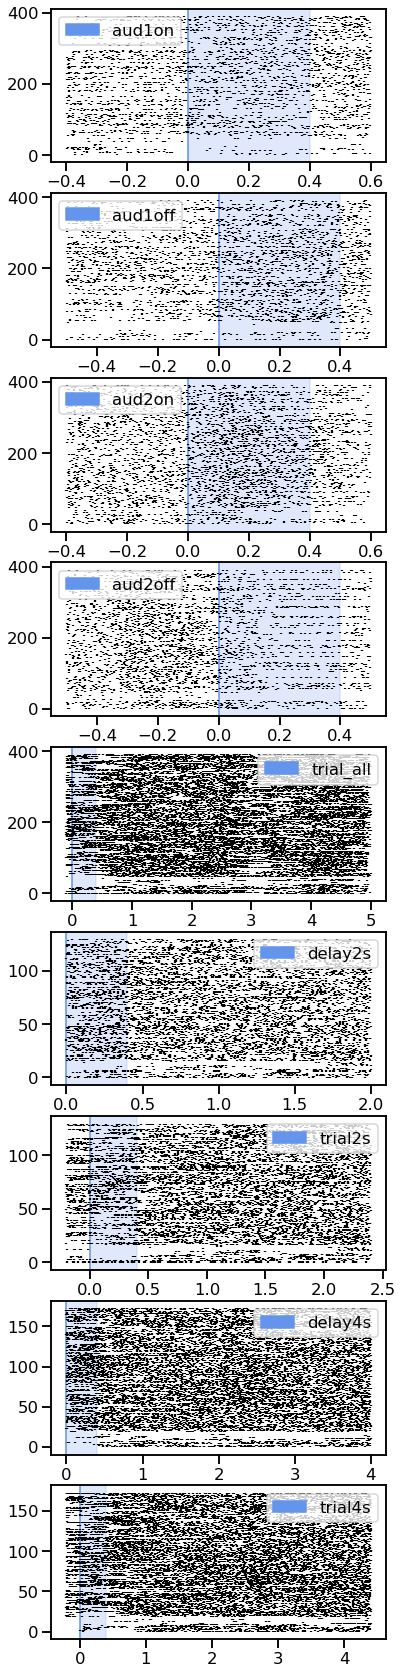

In [65]:
fig, ax = plt.subplots(len(neuron_a), 1, figsize=(6,30))

for idx, key in enumerate(neuron_a.keys()):
    _ = ax[idx].eventplot(neuron_a[key],colors = 'black')
    ax[idx].axvspan(0,0.000001, color = 'cornflowerblue', label = key)
    ax[idx].axvspan(0,0.4, alpha = 0.2, color = 'cornflowerblue')
    ax[idx].legend()
    

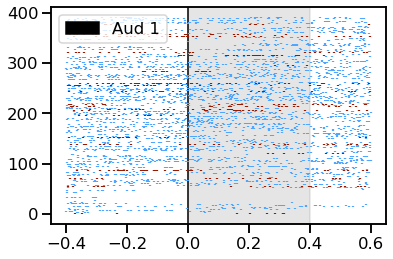

In [111]:
t = (beh_df['hit_hist'] =='hit').to_numpy()
new = np.where(t == True, '#4DA6FF', '#991900')

_ = plt.eventplot(neuron_a['aud1on'], color = new)
plt.axvspan(0,0.4, alpha = 0.2, color = 'grey')
plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
plt.legend()

## non function code

In [83]:
test = binarize_event(sess_aligned[2]['delay2s'],[-150,2150], 0.001)
mu = 0
sigma = .150
x = np.linspace(-1.0, 1.0, 150)
ker = make_gaussian_kernal(x, mu, sigma)

# make kernal
kernal = make_gaussian_kernal(x, mu, sigma)

# convolve 
m, s, tr = smooth_trials(test, kernal, summary=True)
# for plot
time = np.linspace(-150, 2150, len(m))


No handles with labels found to put in legend.


(0.0, 2000.0)

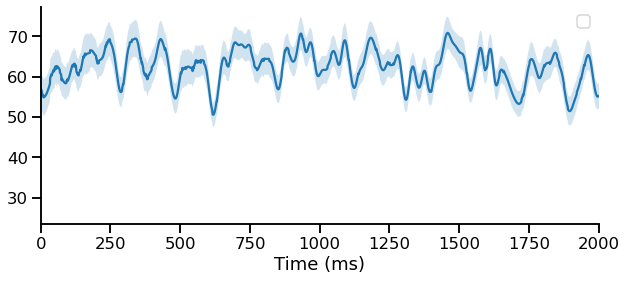

In [206]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(time, m)
ax.fill_between(time, m - s, m + s, alpha = 0.2 )

# plt.axvspan(0,400, alpha = 0.2, color = 'grey')
# plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
ax.set(xlabel = "Time (ms)")
plt.legend()
sns.despine()
plt.xlim(0,2000)
# plt.ylim(0.01, 0.05)

#### scipy stats

seems not to work when y axis output is < 1 

In [59]:
# these are names in the beh_df
df_event = ['aud1_on', 'aud1_off', 'aud2_on', 'aud2_off', 'aud1_on']
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000]]


aligned_spk_times = {}

for event,name,window in zip(df_event,names,windows):
    rowsL = []
    aligned_spk_times[name] = []
    
    for itrial, row in beh_df.iterrows():
        
        trial_spks = neuron1_spks['trial_spks'][itrial]

        # grab alignment time
        align_time = row[event]
        
        # create windows
        start = align_time + (window[0] * 0.001)
        stop  = align_time + (window[1] * 0.001)  
        
         # grab spks in the window
        spks_in_window = trial_spks[np.logical_and(trial_spks > start, trial_spks < stop)]
        event_aligned = spks_in_window - align_time
        
        # append
        aligned_spk_times[name].append(event_aligned)
        

In [102]:
# delay

def delay_align(beh_df, trial_spks):
    delay_windows = [[0, 2000],[-200, 2400], [0, 4000], [-200, 4400]]
    delay_names = ['delay2s', 'trial2s', 'delay4s', 'trial4s']


L =[[],[],[],[]]


    for itrial, row in beh_df.iterrows():

        trial_spks = neuron1_spks['trial_spks'][itrial]
        d_align_time = row['aud1_off']
        t_align_time = row['aud1_on']

        if row['delay'] == 2:

            d = 0
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 1
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)

        elif row['delay'] == 4:

            d = 2 
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 3
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)


    delay_info = dict(zip(delay_names, L))